In [2]:
import numpy as np
import pandas as pd

In [3]:
train_df = pd.read_csv('../train.csv',index_col="tripid")

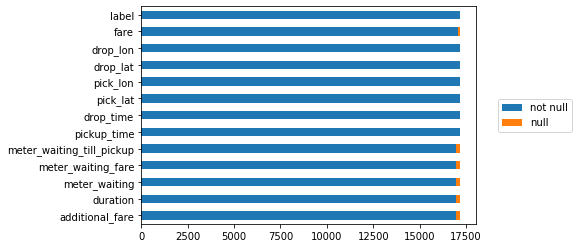

In [4]:
ax = pd.DataFrame({'not null': train_df.count(),
                   'null': train_df.isnull().sum()}).plot.barh(stacked=True)

ax.legend(
    loc='center left', 
    bbox_to_anchor=(1.05, 0.5)
)

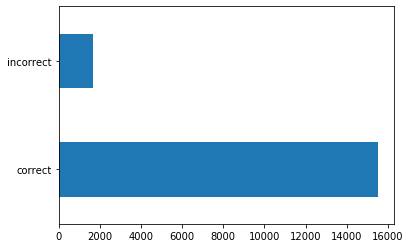

In [5]:
train_df['label'].value_counts().plot.barh()

In [6]:
from sklearn.preprocessing import label_binarize
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import RobustScaler

RANDOM_SEED = 42  

In [7]:
labels_raw_df = train_df.loc[:, train_df.columns == 'label']
features_raw_df = train_df.drop(columns=['label'])

In [8]:
def preprocess_labels(input_labels_df):
  labels_df = input_labels_df
  labels_df = pd.DataFrame(label_binarize(labels_df, classes=['incorrrect', 'correct']))
  
  labels_df.columns = labels_df.columns
  labels_df.index = labels_df.index

  return labels_df  

In [9]:
labels_df = preprocess_labels(labels_raw_df)

In [39]:
def preprocess_features(input_features_df):
    features_df = input_features_df.copy()
    
    numeric_cols = features_df.columns[features_df.dtypes != "object"].values
    
    non_numeric_cols = features_df.columns[features_df.dtypes == "object"].values
    
    #numeric
    scaler = RobustScaler()
    features_df[numeric_cols] = scaler.fit_transform(features_df[numeric_cols])

    imputer = SimpleImputer(strategy='mean')
    features_df[numeric_cols] = imputer.fit_transform(features_df[numeric_cols])

    #date time
    features_df['pickup_time'] = pd.to_datetime(features_df['pickup_time'])
    features_df['drop_time'] = pd.to_datetime(features_df['drop_time'])
    
    #features_df['pickup_day_of_week'] = features_df['pickup_time'].dt.day_name()
    #features_df['drop_day_of_week'] = features_df['drop_time'].dt.day_name()
    
    features_df['pickup_hour'] = features_df['pickup_time'].dt.hour
    features_df['drop_hour'] = features_df['drop_time'].dt.hour
    
    #features_df = pd.get_dummies(features_df, columns = ['pickup_day_of_week', 'drop_day_of_week'])
    
    features_df = features_df.drop(columns=['pickup_time','drop_time'])
    
    return features_df

In [40]:
features_df = preprocess_features(features_raw_df)

In [47]:
test_features_raw_df = pd.read_csv('../test.csv',index_col="tripid")
test_features_df = preprocess_features(test_features_raw_df)

In [42]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import f1_score, confusion_matrix

from sklearn.model_selection import train_test_split, cross_val_score

from bayes_opt import BayesianOptimization

import matplotlib.pyplot as plt


RANDOM_SEED = 4
thresh = 5

In [24]:
x_train, x_eval, y_train, y_eval = train_test_split(
    features_df,
    labels_df,
    test_size=0.2,
    shuffle=True,
    stratify=labels_df,
    random_state=RANDOM_SEED
)

In [84]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
train_results = []
test_results = []
for estimator in n_estimators:
    rf = RandomForestClassifier(n_estimators=estimator, bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                           criterion='gini', max_depth=149, max_features='auto',
                           max_leaf_nodes=None, max_samples=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=7,
                           min_weight_fraction_leaf=0.0,
                           n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                           warm_start=False)
    rf.fit(x_train, y_train.values.ravel())
    train_pred = rf.predict(x_train)
    f1 = f1_score(train_pred, y_train)
    train_results.append(f1)
    y_pred = rf.predict(x_eval)
    f1 = f1_score(y_pred, y_eval)
    test_results.append(f1)

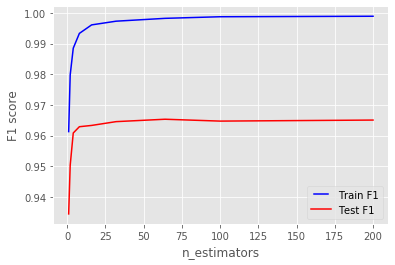

Max Test F1 Score at >  64  :   0.9653106275622833
Max TrainF1 Score at >  200  :   0.9989096636110325


In [85]:
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, 'b', label='Train F1')
line2, = plt.plot(n_estimators, test_results, 'r', label='Test F1')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('F1 score')

plt.xlabel('n_estimators')
plt.show()

import operator
max_index, max_value = max(enumerate(test_results), key=operator.itemgetter(1))
print("Max Test F1 Score at > ",n_estimators[max_index], " :  ", max_value)
max_index, max_value = max(enumerate(train_results), key=operator.itemgetter(1))
print("Max TrainF1 Score at > ",n_estimators[max_index], " :  ", max_value)

In [86]:
max_depths = np.linspace(1, 240, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
    rf = RandomForestClassifier(n_estimators=64, bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                           criterion='gini', max_depth=max_depth, max_features='auto',
                           max_leaf_nodes=None, max_samples=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=7,
                           min_weight_fraction_leaf=0.0,
                           n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                           warm_start=False)
    rf.fit(x_train, y_train.values.ravel())
    train_pred = rf.predict(x_train)
    f1 = f1_score(train_pred, y_train)
    train_results.append(f1)
    y_pred = rf.predict(x_eval)
    f1 = f1_score(y_pred, y_eval)
    test_results.append(f1)

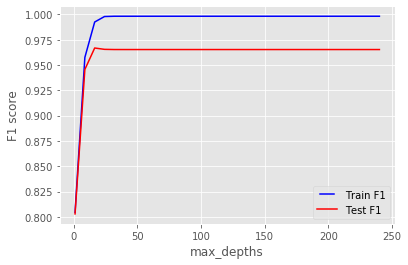

Max Test F1 Score at >  16.41935483870968  :   0.9668246445497629
Max Train F1 Score at >  31.838709677419356  :   0.9982239444578994


In [87]:
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label='Train F1')
line2, = plt.plot(max_depths, test_results, 'r', label='Test F1')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('F1 score')
plt.xlabel('max_depths')
plt.show()

import operator
max_index, max_value = max(enumerate(test_results), key=operator.itemgetter(1))
print("Max Test F1 Score at > ",max_depths[max_index], " :  ", max_value)
max_index, max_value = max(enumerate(train_results), key=operator.itemgetter(1))
print("Max Train F1 Score at > ",max_depths[max_index], " :  ", max_value)

In [100]:
min_samples_splits = np.linspace(2, 30, 10, endpoint=True)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
    rf = RandomForestClassifier(n_estimators=25, bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                           criterion='gini', max_depth=25, max_features='auto',
                           max_leaf_nodes=None, max_samples=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=int(min_samples_split),
                           min_weight_fraction_leaf=0.0,
                           n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                           warm_start=False)
    rf.fit(x_train, y_train.values.ravel())
    train_pred = rf.predict(x_train)
    f1 = f1_score(train_pred, y_train)
    train_results.append(f1)
    y_pred = rf.predict(x_eval)
    f1 = f1_score(y_pred, y_eval)
    test_results.append(f1)

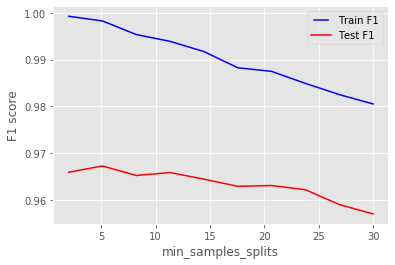

Max Test F1 Score at >  5.111111111111111  :   0.9672544080604535
Max Train F1 Score at >  2.0  :   0.999274369104249


In [101]:
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_splits, train_results, 'b', label='Train F1')
line2, = plt.plot(min_samples_splits, test_results, 'r', label='Test F1')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('F1 score')
plt.xlabel('min_samples_splits')
plt.show()

import operator
max_index, max_value = max(enumerate(test_results), key=operator.itemgetter(1))
print("Max Test F1 Score at > ", min_samples_splits[max_index], " :  ", max_value)
max_index, max_value = max(enumerate(train_results), key=operator.itemgetter(1))
print("Max Train F1 Score at > ", min_samples_splits[max_index], " :  ", max_value)

In [102]:
min_samples_leafs = np.linspace(1, 10, 10, endpoint=True)
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
    rf = RandomForestClassifier(n_estimators=25, bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                           criterion='gini', max_depth=50, max_features='auto',
                           max_leaf_nodes=None, max_samples=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=int(min_samples_leaf), min_samples_split=5,
                           min_weight_fraction_leaf=0.0,
                           n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                           warm_start=False)
    rf.fit(x_train, y_train.values.ravel())
    train_pred = rf.predict(x_train)
    f1 = f1_score(train_pred, y_train)
    train_results.append(f1)
    y_pred = rf.predict(x_eval)
    f1 = f1_score(y_pred, y_eval)
    test_results.append(f1)

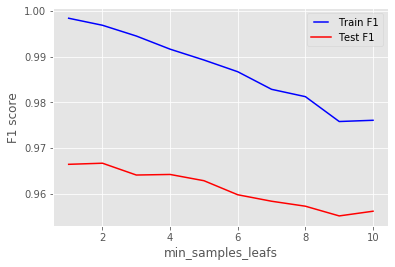

Max Test F1 Score at >  2.0  :   0.9666929755327545
Max Train F1 Score at >  1.0  :   0.9983872268365455


In [103]:
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_leafs, train_results, 'b', label='Train F1')
line2, = plt.plot(min_samples_leafs, test_results, 'r', label='Test F1')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('F1 score')
plt.xlabel('min_samples_leafs')
plt.show()

import operator
max_index, max_value = max(enumerate(test_results), key=operator.itemgetter(1))
print("Max Test F1 Score at > ", min_samples_leafs[max_index], " :  ", max_value)
max_index, max_value = max(enumerate(train_results), key=operator.itemgetter(1))
print("Max Train F1 Score at > ", min_samples_leafs[max_index], " :  ", max_value)

In [104]:
max_features = list(range(1,x_train.shape[1]))
train_results = []
test_results = []

for max_feature in max_features:
    rf = RandomForestClassifier(n_estimators=25, bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                           criterion='gini', max_depth=50, max_features=max_feature,
                           max_leaf_nodes=None, max_samples=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=2, min_samples_split=11,
                           min_weight_fraction_leaf=0.0,
                           n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                           warm_start=False)
    rf.fit(x_train, y_train.values.ravel())
    train_pred = rf.predict(x_train)
    f1 = f1_score(train_pred, y_train)
    train_results.append(f1)
    y_pred = rf.predict(x_eval)
    f1 = f1_score(y_pred, y_eval)
    test_results.append(f1)

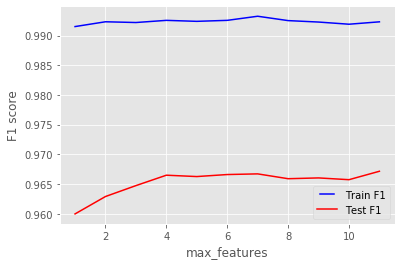

Max Test F1 Score at >  11  :   0.9671451355661881
Max Train F1 Score at >  7  :   0.9932473413933929


In [105]:
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_features, train_results, 'b', label='Train F1')
line2, = plt.plot(max_features, test_results, 'r', label='Test F1')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('F1 score')
plt.xlabel('max_features')
plt.show()

import operator
max_index, max_value = max(enumerate(test_results), key=operator.itemgetter(1))
print("Max Test F1 Score at > ", max_features[max_index], " :  ", max_value)
max_index, max_value = max(enumerate(train_results), key=operator.itemgetter(1))
print("Max Train F1 Score at > ", max_features[max_index], " :  ", max_value)

## With Day

In [19]:
rf = RandomForestClassifier(n_estimators=25, bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                           criterion='gini', max_depth=50, max_features=21,
                           max_leaf_nodes=None, max_samples=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=2, min_samples_split=11,
                           min_weight_fraction_leaf=0.0,
                           n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                           warm_start=False)

rf.fit(x_train, y_train.values.ravel())

ValueError: could not convert string to float: 'Sunday'

In [46]:
y_pred = rf.predict(x_eval)

print(f'F1 score: {f1_score(y_eval, y_pred)}')
print(f'F1 score: {f1_score(y_eval, y_pred, average="macro")}')

F1 score: 0.9661989795918369
F1 score: 0.8064328231292517


In [54]:
feature_list = list(features_df.columns)
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
#[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

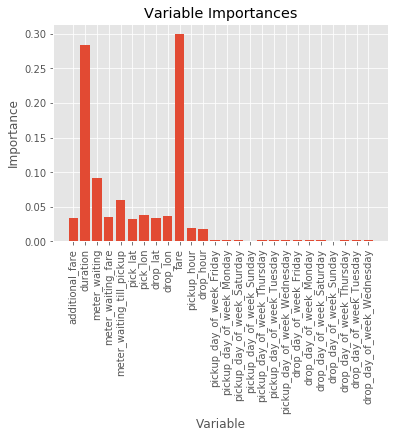

In [48]:
# Set the style
plt.style.use('ggplot')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');


## Without Days

In [72]:
def preprocess_features(input_features_df):
    features_df = input_features_df.copy()
    
    #date time
    features_df['pickup_time'] = pd.to_datetime(features_df['pickup_time'])
    features_df['drop_time'] = pd.to_datetime(features_df['drop_time'])
    
    #duration
    features_df['duration_fill'] = (features_df['drop_time'] - features_df['pickup_time']).dt.total_seconds()
    features_df['duration'] = features_df['duration'].fillna(features_df['duration_fill'])
    
    features_df = features_df.drop(columns=['duration_fill'])

    #travel time
    features_df['travel_time'] = features_df['duration'] - features_df['meter_waiting']
    
    #waiting time
    features_df['waiting_time'] = features_df['meter_waiting'] + features_df['meter_waiting_till_pickup']
    
    #distance fare
    features_df['distance_fare'] = features_df['fare'] - features_df['meter_waiting_fare'] - features_df['additional_fare']
   
    #distance
    features_df['manhattan_distance'] = abs(features_df['drop_lat'] - features_df['pick_lat']) + abs(features_df['drop_lon'] - features_df['pick_lon'])

    #get day of the week
    features_df['pickup_day_of_week'] = features_df['pickup_time'].dt.day_name()
    features_df['drop_day_of_week'] = features_df['drop_time'].dt.day_name()
    
    features_df['pickup_hour_float'] = features_df['pickup_time'].dt.hour + features_df['pickup_time'].dt.minute/60
    features_df['drop_hour_float'] = features_df['drop_time'].dt.hour + features_df['drop_time'].dt.minute/60

    
    #encode cyclic 24 hours with sin and cos
    features_df['sin_pickup_time'] = np.sin(2*np.pi*features_df.pickup_hour_float/24.)
    features_df['cos_pickup_time'] = np.cos(2*np.pi*features_df.pickup_hour_float/24.)

    features_df['sin_drop_time'] = np.sin(2*np.pi*features_df.drop_hour_float/24.)
    features_df['cos_drop_time'] = np.cos(2*np.pi*features_df.drop_hour_float/24.)
    
    features_df = pd.get_dummies(features_df, columns = ['pickup_day_of_week', 'drop_day_of_week'])
    
    features_df = features_df.drop(columns=['pickup_time','drop_time', 'pickup_hour_float', 'drop_hour_float'])
    
    numeric_cols = features_df.columns[features_df.dtypes != "object"].values
    
    non_numeric_cols = features_df.columns[features_df.dtypes == "object"].values
    
    #numeric
    scaler = RobustScaler()
    features_df[numeric_cols] = scaler.fit_transform(features_df[numeric_cols])

    imputer = SimpleImputer(strategy='mean')
    features_df[numeric_cols] = imputer.fit_transform(features_df[numeric_cols])
    
    return features_df

In [73]:
features_df = preprocess_features(features_raw_df)

In [74]:
test_features_df = preprocess_features(test_features_raw_df)

In [75]:
x_train, x_eval, y_train, y_eval = train_test_split(
    features_df,
    labels_df,
    test_size=0.2,
    shuffle=True,
    stratify=labels_df,
    random_state=RANDOM_SEED
)

In [76]:
rf = RandomForestClassifier(n_estimators=25, bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                           criterion='gini', max_depth=50, max_features=11,
                           max_leaf_nodes=None, max_samples=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=2, min_samples_split=11,
                           min_weight_fraction_leaf=0.0,
                           n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                           warm_start=False)

rf.fit(x_train, y_train.values.ravel())

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=50, max_features=11,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=11,
                       min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [77]:
#Imputer Simple Mean
y_pred = rf.predict(x_eval)
from sklearn.metrics import fbeta_score

print(f'F1 score: {f1_score(y_eval, y_pred)}')
print(f'F1 score: {f1_score(y_eval, y_pred, average="macro")}')

F1 score: 0.9718107978977545
F1 score: 0.8366642522372415


In [78]:
test_pred = rf.predict(test_features_df)

In [79]:
submission_df = pd.read_csv('../sample_submission.csv',index_col="tripid")

np.testing.assert_array_equal(test_features_df.index.values, 
                              submission_df.index.values)
    
submission_df["prediction"] = test_pred

submission_df.to_csv('../submission_test2.csv', index=True)

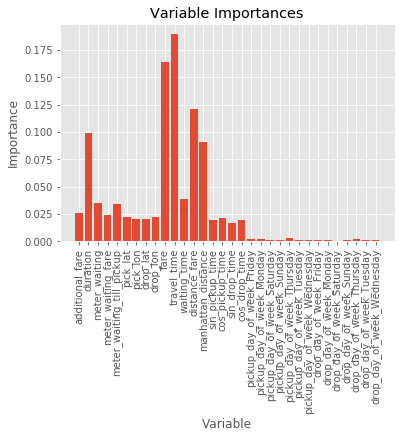

In [80]:
feature_list = list(features_df.columns)
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
#[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];
# Set the style
plt.style.use('ggplot')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

In [61]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
train_results = []
test_results = []
for estimator in n_estimators:
    rf = RandomForestClassifier(n_estimators=estimator, bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                           criterion='gini', max_depth=149, max_features='auto',
                           max_leaf_nodes=None, max_samples=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=7,
                           min_weight_fraction_leaf=0.0,
                           n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                           warm_start=False)
    rf.fit(x_train, y_train.values.ravel())
    train_pred = rf.predict(x_train)
    f1 = f1_score(train_pred, y_train)
    train_results.append(f1)
    y_pred = rf.predict(x_eval)
    f1 = f1_score(y_pred, y_eval)
    test_results.append(f1)

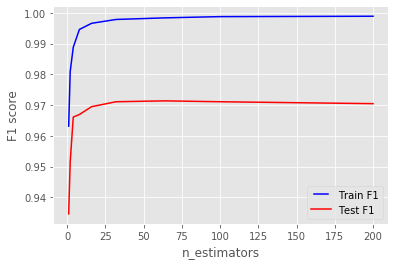

Max Test F1 Score at >  64  :   0.9713833992094862
Max TrainF1 Score at >  200  :   0.9989097516656572


In [62]:
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, 'b', label='Train F1')
line2, = plt.plot(n_estimators, test_results, 'r', label='Test F1')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('F1 score')

plt.xlabel('n_estimators')
plt.show()

import operator
max_index, max_value = max(enumerate(test_results), key=operator.itemgetter(1))
print("Max Test F1 Score at > ",n_estimators[max_index], " :  ", max_value)
max_index, max_value = max(enumerate(train_results), key=operator.itemgetter(1))
print("Max TrainF1 Score at > ",n_estimators[max_index], " :  ", max_value)

In [153]:
max_depths = np.linspace(1, 240, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
    rf = RandomForestClassifier(n_estimators=32, bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                           criterion='gini', max_depth=max_depth, max_features='auto',
                           max_leaf_nodes=None, max_samples=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=7,
                           min_weight_fraction_leaf=0.0,
                           n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                           warm_start=False)
    rf.fit(x_train, y_train.values.ravel())
    train_pred = rf.predict(x_train)
    f1 = f1_score(train_pred, y_train)
    train_results.append(f1)
    y_pred = rf.predict(x_eval)
    f1 = f1_score(y_pred, y_eval)
    test_results.append(f1)

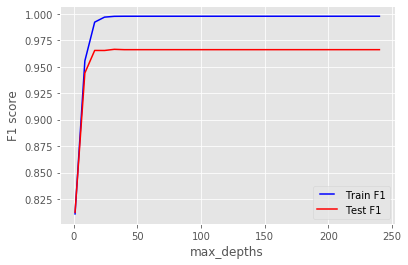

Max Test F1 Score at >  31.838709677419356  :   0.9664725326617347
Max Train F1 Score at >  39.54838709677419  :   0.9977415712211647


In [154]:
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label='Train F1')
line2, = plt.plot(max_depths, test_results, 'r', label='Test F1')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('F1 score')
plt.xlabel('max_depths')
plt.show()

import operator
max_index, max_value = max(enumerate(test_results), key=operator.itemgetter(1))
print("Max Test F1 Score at > ",max_depths[max_index], " :  ", max_value)
max_index, max_value = max(enumerate(train_results), key=operator.itemgetter(1))
print("Max Train F1 Score at > ",max_depths[max_index], " :  ", max_value)

In [155]:
min_samples_splits = np.linspace(2, 30, 10, endpoint=True)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
    rf = RandomForestClassifier(n_estimators=25, bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                           criterion='gini', max_depth=32, max_features='auto',
                           max_leaf_nodes=None, max_samples=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=int(min_samples_split),
                           min_weight_fraction_leaf=0.0,
                           n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                           warm_start=False)
    rf.fit(x_train, y_train.values.ravel())
    train_pred = rf.predict(x_train)
    f1 = f1_score(train_pred, y_train)
    train_results.append(f1)
    y_pred = rf.predict(x_eval)
    f1 = f1_score(y_pred, y_eval)
    test_results.append(f1)

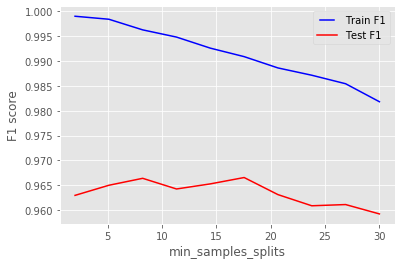

Max Test F1 Score at >  17.555555555555557  :   0.9665344964314035
Max Train F1 Score at >  2.0  :   0.999032804062223


In [156]:
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_splits, train_results, 'b', label='Train F1')
line2, = plt.plot(min_samples_splits, test_results, 'r', label='Test F1')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('F1 score')
plt.xlabel('min_samples_splits')
plt.show()

import operator
max_index, max_value = max(enumerate(test_results), key=operator.itemgetter(1))
print("Max Test F1 Score at > ", min_samples_splits[max_index], " :  ", max_value)
max_index, max_value = max(enumerate(train_results), key=operator.itemgetter(1))
print("Max Train F1 Score at > ", min_samples_splits[max_index], " :  ", max_value)

In [157]:
min_samples_leafs = np.linspace(1, 10, 10, endpoint=True)
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
    rf = RandomForestClassifier(n_estimators=25, bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                           criterion='gini', max_depth=50, max_features='auto',
                           max_leaf_nodes=None, max_samples=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=int(min_samples_leaf), min_samples_split=8,
                           min_weight_fraction_leaf=0.0,
                           n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                           warm_start=False)
    rf.fit(x_train, y_train.values.ravel())
    train_pred = rf.predict(x_train)
    f1 = f1_score(train_pred, y_train)
    train_results.append(f1)
    y_pred = rf.predict(x_eval)
    f1 = f1_score(y_pred, y_eval)
    test_results.append(f1)

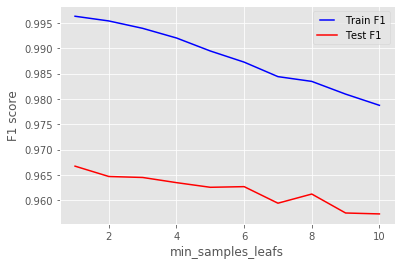

Max Test F1 Score at >  1.0  :   0.9667139927433349
Max Train F1 Score at >  1.0  :   0.996327831806626


In [158]:
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_leafs, train_results, 'b', label='Train F1')
line2, = plt.plot(min_samples_leafs, test_results, 'r', label='Test F1')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('F1 score')
plt.xlabel('min_samples_leafs')
plt.show()

import operator
max_index, max_value = max(enumerate(test_results), key=operator.itemgetter(1))
print("Max Test F1 Score at > ", min_samples_leafs[max_index], " :  ", max_value)
max_index, max_value = max(enumerate(train_results), key=operator.itemgetter(1))
print("Max Train F1 Score at > ", min_samples_leafs[max_index], " :  ", max_value)

In [159]:
max_features = list(range(1,x_train.shape[1]))
train_results = []
test_results = []

for max_feature in max_features:
    rf = RandomForestClassifier(n_estimators=25, bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                           criterion='gini', max_depth=50, max_features=max_feature,
                           max_leaf_nodes=None, max_samples=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=11,
                           min_weight_fraction_leaf=0.0,
                           n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                           warm_start=False)
    rf.fit(x_train, y_train.values.ravel())
    train_pred = rf.predict(x_train)
    f1 = f1_score(train_pred, y_train)
    train_results.append(f1)
    y_pred = rf.predict(x_eval)
    f1 = f1_score(y_pred, y_eval)
    test_results.append(f1)

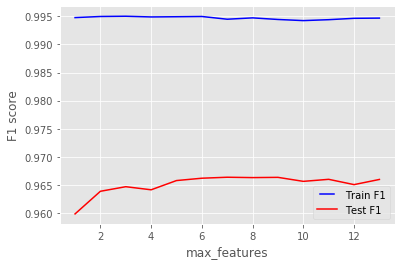

Max Test F1 Score at >  7  :   0.9663918833227647
Max Train F1 Score at >  3  :   0.99499596448749


In [160]:
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_features, train_results, 'b', label='Train F1')
line2, = plt.plot(max_features, test_results, 'r', label='Test F1')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('F1 score')
plt.xlabel('max_features')
plt.show()

import operator
max_index, max_value = max(enumerate(test_results), key=operator.itemgetter(1))
print("Max Test F1 Score at > ", max_features[max_index], " :  ", max_value)
max_index, max_value = max(enumerate(train_results), key=operator.itemgetter(1))
print("Max Train F1 Score at > ", max_features[max_index], " :  ", max_value)